In [4]:
## This code was a failed first attempt.
"""
import numpy as np

def mos(f, phi, t_0, t_f, tau, N):
    
    ## Preliminaries
    h = (t_f - t_0) / N
    n_intervals = int(t_f // tau + 1) if t_f // tau < t_f / tau else int(t_f // tau)
    T = n_intervals * tau

    t = np.linspace(-tau, 0, N+1)
    phi = np.vectorize(phi)
    y = phi(t)

    for n in range(0, n_intervals):
        t_new = np.linspace(n*tau, (n+1)*tau, N+1)
        y_new = np.zeros(len(t_new))
        y_new[0] = y[-1]
        for i in range(0, N):
            y_delayed = y[-(N-i)]
            y_new[i+1] = y_new[i] + h*f(t_new[i], y_new[i], y_delayed)
        y = np.concatenate((y, y_new[1:]))
        t = np.concatenate((t, t_new[1:]))

    return h, t, y
"""

'\nimport numpy as np\n\ndef mos(f, phi, t_0, t_f, tau, N):\n    \n    ## Preliminaries\n    h = (t_f - t_0) / N\n    n_intervals = int(t_f // tau + 1) if t_f // tau < t_f / tau else int(t_f // tau)\n    T = n_intervals * tau\n\n    t = np.linspace(-tau, 0, N+1)\n    phi = np.vectorize(phi)\n    y = phi(t)\n\n    for n in range(0, n_intervals):\n        t_new = np.linspace(n*tau, (n+1)*tau, N+1)\n        y_new = np.zeros(len(t_new))\n        y_new[0] = y[-1]\n        for i in range(0, N):\n            y_delayed = y[-(N-i)]\n            y_new[i+1] = y_new[i] + h*f(t_new[i], y_new[i], y_delayed)\n        y = np.concatenate((y, y_new[1:]))\n        t = np.concatenate((t, t_new[1:]))\n\n    return h, t, y\n'

### Explicit Euler:

In [6]:
import numpy as np

## Linear interpolation for delay terms
def y_delayed(t, y, t_q):
    j = np.searchsorted(t, t_q)
    j1, j2 = j-1, j
    w = (t_q - t[j1]) / (t[j2] - t[j1])
    y_delayed = (1 - w) * y[j1] + w * y[j2]
    return y_delayed


## Note: In case of implicit methods, we must make sure that h < tau,
## otherwise the interpolation will ask for values of y which have not yet been calculated.


## Explicit Euler
def EE(f, phi, t_0, t_f, tau, N, history=False):

    ## Preliminaries
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros(len(t))
    y[0] = phi(t_0)

    ## EE with linear interpolation for delay term
    for i in range(0, N):
        if t[i] < tau:
            y[i+1] = y[i] + h*f(t[i], y[i], phi(t[i] - tau)) ## We have exact values for these delay terms, let's use them
        else:
            y[i+1] = y[i] + h*f(t[i], y[i], y_delayed(t, y, t[i] - tau)) ## We need to use linear interpolation for these delay terms

    if history == True: ## Wether the solution should include the history (values on the interval [t_0 - tau, t_0])
        t_hist = np.linspace(t_0-tau, t_0, int(N / (t_f // tau) + 1))
        y_hist = np.array([phi(ti) for ti in t_hist])
        t = np.concatenate((t_hist, t))
        y = np.concatenate((y_hist, y))

    return h, t, y

In [7]:
from math import factorial

## Right-hand-side of the simple DDE
def simple(a):
    def simple_dde(t, y1, y2):
        return -a*y2
    return simple_dde


## Constant one history function
def phi_0(t):
    return 1

## Exact solution FOR THE SIMPLE DDE ONLY with constant 1 history function, starting at t_0 = 0:
## Note that this doesn't work for arbitrarily large time intervals, because the terms in the sum blow up,
##    leading to errors caused by floating-point arithmetic.
def simple_exact(a, t_0, t_f, tau, N):
    if t_0 != 0:
        raise ValueError("t_0 should be set to 0")
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros(len(t))
    for i, ti in enumerate(t):
        n = int(np.floor(ti / tau)) + 1
        y[i] = 1
        for k in range(1, n+1):
            y[i] += (-a)**k * (ti - (k-1)*tau)**k / factorial(k)
    return y

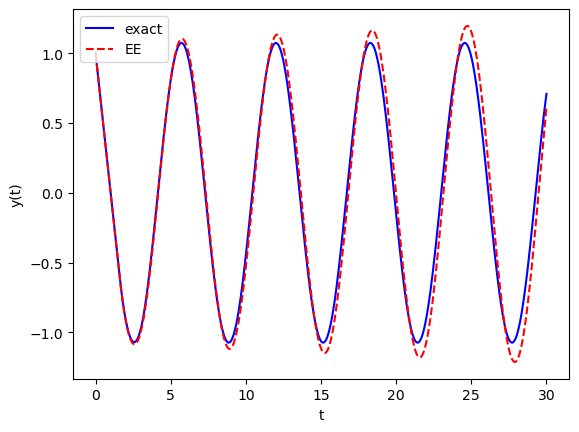

In [8]:
import matplotlib.pyplot as plt

a = 1
t_0 = 0
t_f = 30
tau = np.pi / 2
N = 10**3

h, t, y = EE(simple(a), phi_0, t_0, t_f, tau, N, False)
exact = simple_exact(a, t_0, t_f, tau, N)

plt.plot(t, exact, color='blue', label='exact')
plt.plot(t, y, 'r--', label='EE')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
#plt.plot(t, np.zeros(len(t)), color='black')

### Implicit Euler:

In [10]:
from scipy.optimize import fsolve

## Implicit Euler
def IE(f, phi, t_0, t_f, tau, N, history=False):

    ## Preliminaries
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros(len(t))
    y[0] = phi(t_0)
    
    ## IE with linear interpolation for delay term
    for i in range(0, N):
        if t[i] < tau:
            y_impl = lambda x : -x + y[i] + h*f(t[i+1], x, phi(t[i+1] - tau))
            y[i+1] = fsolve(y_impl, [y[i]])[0]
        else:
            y_impl = lambda x : -x + y[i] + h*f(t[i+1], x, y_delayed(t, y, t[i+1] - tau))
            y[i+1] = fsolve(y_impl, [y[i]])[0]

    if history == True: ## Wether the solution should include the history (values on the interval [t_0 - tau, t_0])
        t_hist = np.linspace(t_0-tau, t_0, int(N / (t_f // tau) + 1))
        y_hist = np.array([phi(ti) for ti in t_hist])
        t = np.concatenate((t_hist, t))
        y = np.concatenate((y_hist, y))

    return h, t, y

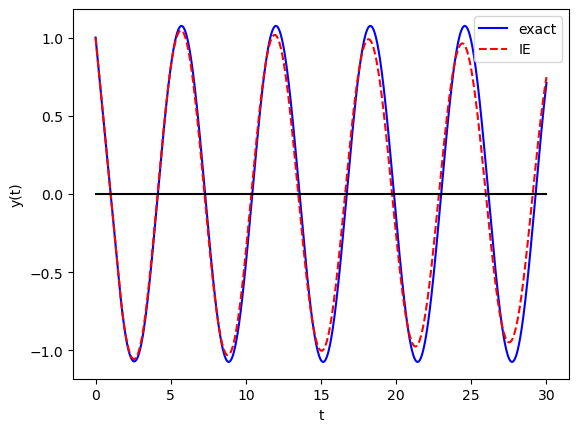

In [58]:
import matplotlib.pyplot as plt

a = 1
t_0 = 0
t_f = 30
tau = np.pi / 2
N = 10**3

h, t, y = IE(simple(a), phi_0, t_0, t_f, tau, N, False)
exact = simple_exact(a, t_0, t_f, tau, N)

plt.plot(t, exact, color='blue', label='exact')
plt.plot(t, y, 'r--', label='IE')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.plot(t, np.zeros(len(t)), color='black')

### Trapezoidal rule:

In [13]:
def Trapezoidal(f, phi, t_0, t_f, tau, N, history=False):

    ## Preliminaries
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros(len(t))
    y[0] = phi(t_0)

    ## Trapezoidal rule with linear interpolation for delay term
    for i in range(0, N):
        if t[i] < tau:
            y_impl = lambda x : -x + y[i] + h*f(t[i+1], x, phi(t[i+1] - tau))
            y[i+1] = 1/2*(y[i] + h*f(t[i], y[i], phi(t[i] - tau))) + 1/2*fsolve(y_impl, [y[i]])[0]
        else:
            y_impl = lambda x : -x + y[i] + h*f(t[i+1], x, y_delayed(t, y, t[i+1] - tau))
            y[i+1] = 1/2*(y[i] + h*f(t[i], y[i], y_delayed(t, y, t[i] - tau))) + 1/2*fsolve(y_impl, [y[i]])[0]

    if history == True: ## Wether the solution should include the history (values on the interval [t_0 - tau, t_0])
        t_hist = np.linspace(t_0-tau, t_0, int(N / (t_f // tau) + 1))
        y_hist = np.array([phi(ti) for ti in t_hist])
        t = np.concatenate((t_hist, t))
        y = np.concatenate((y_hist, y))

    return h, t, y

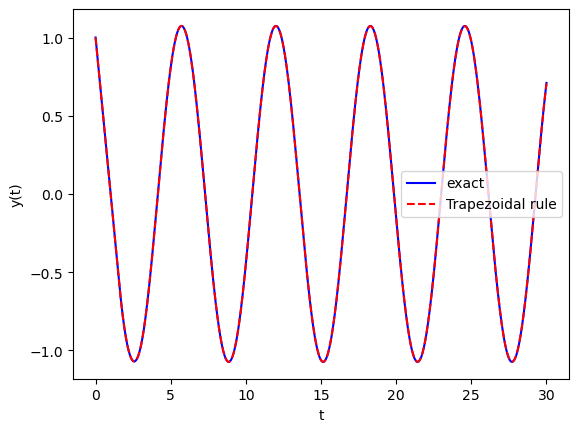

In [14]:
import matplotlib.pyplot as plt

a = 1
t_0 = 0
t_f = 30
tau = np.pi / 2
N = 10**3

h, t, y = Trapezoidal(simple(a), phi_0, t_0, t_f, tau, N, False)
exact = simple_exact(a, t_0, t_f, tau, N)

plt.plot(t, exact, color='blue', label='exact')
plt.plot(t, y, 'r--', label='Trapezoidal rule')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
#plt.plot(t, np.zeros(len(t)), color='black')

### RK4:

In [16]:
def RK4(f, phi, t_0, t_f, tau, N, history=False):

    ## Preliminaries
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros(len(t))
    y[0] = phi(t_0)

    ## RK4 with linear interpolation for delay term
    for i in range(0, N):
        if t[i] < tau:
            k1 = f(t[i], y[i], phi(t[i] - tau))
            k2 = f(t[i] + 0.5*h, y[i] + h*0.5*k1, phi(t[i] + 0.5*h - tau))
            k3 = f(t[i] + 0.5*h, y[i] + h*0.5*k2, phi(t[i] + 0.5*h - tau))
            k4 = f(t[i] + h, y[i] + h*k3, phi(t[i] + h - tau))
            y[i+1] = y[i] + h*(k1/6 + k2/3 + k3/3 + k4/6)
        else:
            k1 = f(t[i], y[i], y_delayed(t, y, t[i] - tau))
            k2 = f(t[i] + 0.5*h, y[i] + h*0.5*k1, y_delayed(t, y, t[i] + 0.5*h - tau))
            k3 = f(t[i] + 0.5*h, y[i] + h*0.5*k2, y_delayed(t, y, t[i] + 0.5*h - tau))
            k4 = f(t[i] + h, y[i] + h*k3, y_delayed(t, y, t[i] + h - tau))
            y[i+1] = y[i] + h*(k1/6 + k2/3 + k3/3 + k4/6)

    if history == True: ## Wether the solution should include the history (values on the interval [t_0 - tau, t_0])
        t_hist = np.linspace(t_0-tau, t_0, int(N / (t_f // tau) + 1))
        y_hist = np.array([phi(ti) for ti in t_hist])
        t = np.concatenate((t_hist, t))
        y = np.concatenate((y_hist, y))

    return h, t, y

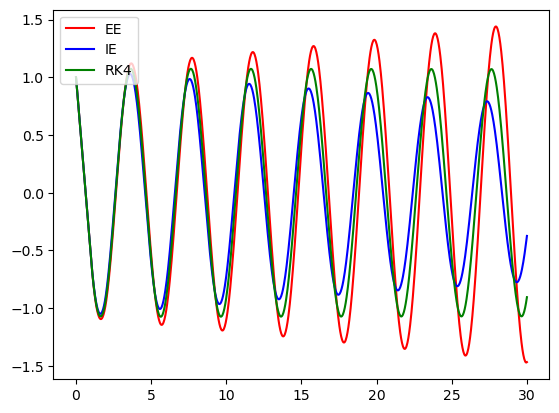

In [17]:
a = np.pi / 2
t_0 = 0
t_f = 30
tau = 1
N = 10**3

## Comparing EE, IE and RK4
h, t, y_ee = EE(simple(a), phi_0, t_0, t_f, tau, N, False)
h, t, y_ie = IE(simple(a), phi_0, t_0, t_f, tau, N, False)
h, t, y_rk4 = RK4(simple(a), phi_0, t_0, t_f, tau, N, False)

plt.plot(t, y_ee, color='red', label='EE')
plt.plot(t, y_ie, color='blue', label='IE')
plt.plot(t, y_rk4, color='green', label='RK4')
plt.legend(loc='upper left')

### RK4 for the system case:

In [19]:
## RK4 for DDEs
def RK4sys_dde(f, phi, t_0, t_f, tau, N, history=False):

    ## Preliminaries
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y0 = phi(t_0)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0

    ## RK4 with linear interpolation for delay term
    for i in range(0, N):
        if t[i] < tau:
            k1 = f(t[i], y[i], phi(t[i] - tau))
            k2 = f(t[i] + 0.5*h, y[i] + h*0.5*k1, phi(t[i] + 0.5*h - tau))
            k3 = f(t[i] + 0.5*h, y[i] + h*0.5*k2, phi(t[i] + 0.5*h - tau))
            k4 = f(t[i] + h, y[i] + h*k3, phi(t[i] + h - tau))
            y[i+1] = y[i] + h*(k1/6 + k2/3 + k3/3 + k4/6)
        else:
            k1 = f(t[i], y[i], y_delayed(t, y, t[i] - tau))
            k2 = f(t[i] + 0.5*h, y[i] + h*0.5*k1, y_delayed(t, y, t[i] + 0.5*h - tau))
            k3 = f(t[i] + 0.5*h, y[i] + h*0.5*k2, y_delayed(t, y, t[i] + 0.5*h - tau))
            k4 = f(t[i] + h, y[i] + h*k3, y_delayed(t, y, t[i] + h - tau))
            y[i+1] = y[i] + h*(k1/6 + k2/3 + k3/3 + k4/6)

    if history == True: ## Wether the solution should include the history (values on the interval [t_0 - tau, t_0])
        t_hist = np.linspace(t_0-tau, t_0, int(N / (t_f // tau) + 1))
        y_hist = np.array([phi(ti) for ti in t_hist])
        t = np.concatenate((t_hist, t))
        y = np.concatenate((y_hist, y))

    return h, t, y

## Regular RK4 for ODEs (for no delay case)
def RK4sys_ode(f, y0, t_0, t_f, N):
    
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros((len(t), len(y0)))
    y[0,:] = y0

    ## RK4
    for n in range(N):
        k1 = f(t[n], y[n])
        k2 = f(t[n] + 0.5*h, y[n] + h*0.5*k1)
        k3 = f(t[n] + 0.5*h, y[n] + h*0.5*k2)
        k4 = f(t[n] + h, y[n] + h*k3)
        y[n+1, :] = y[n] + h*(k1/6 + k2/3 + k3/3 + k4/6)

    return h, t, y

### Further examples:

    (a) SIR
    (b) Logistic growth
    (c) Lotka-Volterra

<b> (a) SIR </b> (Using RK4)

In [22]:
## SIR model with delay
def SIR(beta, gamma):
    def SIR_dde(t, y1, y2):
        S, I, R = y1
        S_d, I_d, R_d = y2
        return np.array([-beta*S*I_d, beta*S*I_d - gamma*I, gamma*I])
    return SIR_dde

## Hisotry function
def phi_SIR(t):
    return np.array([0.8, 0.2, 0])

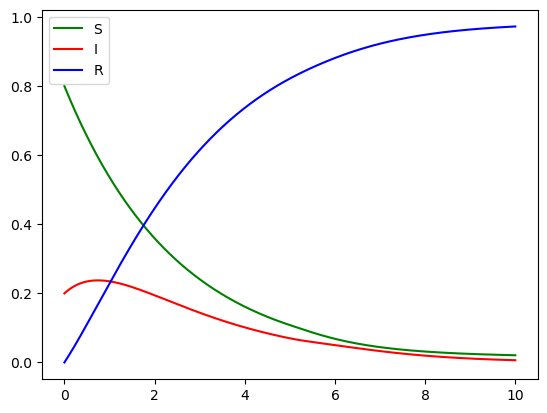

In [23]:
beta = 2
gamma = 1
t_0 = 0
t_f = 10
tau = 5
N = 10**3

h, t, y_rk4 = RK4sys_dde(SIR(beta, gamma), phi_SIR, t_0, t_f, tau, N, False)

S_sol = y_rk4[:,0]
I_sol = y_rk4[:,1]
R_sol = y_rk4[:,2]

plt.plot(t, S_sol, color='green', label='S')
plt.plot(t, I_sol, color='red', label='I')
plt.plot(t, R_sol, color='blue', label='R')
plt.legend()

<b> (b) Logistic Growth </b> (Using EE, IE and RK4)

In [25]:
def Growth(r, K):
    def growth_dde(t, y1, y2):
        return r*y1*(1 - y2 / K)
    return growth_dde

## History function
def phi_lg(t):
    return 10

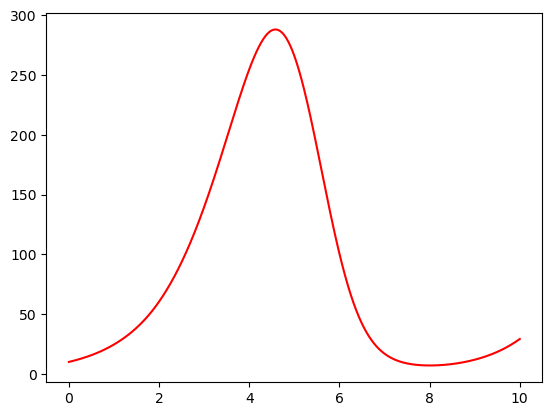

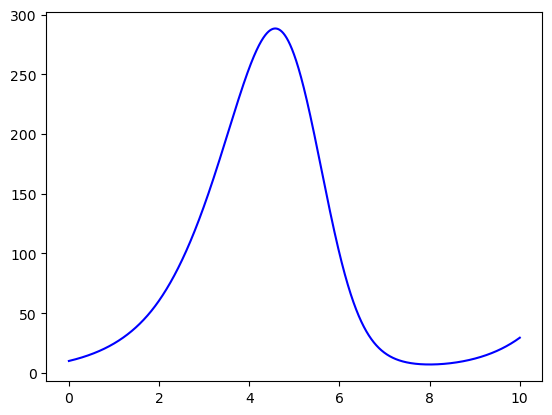

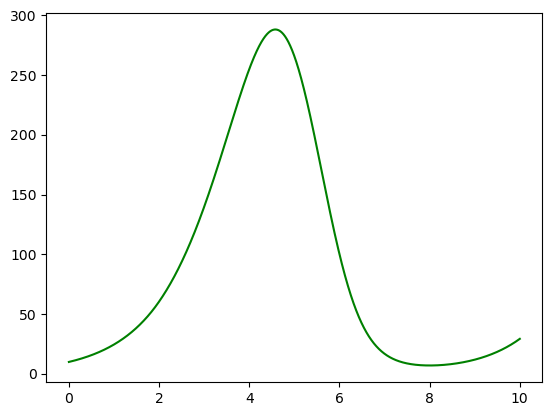

In [26]:
r = 1
K = 100
t_0 = 0
t_f = 10
tau = 2
N = 10**4

h, t, y_ee = EE(Growth(r, K), phi_lg, t_0, t_f, tau, N, False)
h, t, y_ie = IE(Growth(r, K), phi_lg, t_0, t_f, tau, N, False)
h, t, y_rk4 = RK4(Growth(r, K), phi_lg, t_0, t_f, tau, N, False)

plt.plot(t, y_ee, color='red', label='EE')
plt.show()
plt.plot(t, y_ie, color='blue', label='IE')
plt.show()
plt.plot(t, y_rk4, color='green', label='RK4')
plt.show()

<b> (c) Lotka-Volterra </b> (Using RK4 with and without delay)

In [28]:
## Lotka-Volterra with delay
def LotkaVolterra(alpha, beta, gamma, delta):
    def LV_dde(t, y1, y2):
        x, y = y1
        x_d, y_d = y2
        return np.array([alpha*x - beta*x*y_d, delta*x_d*y - gamma*y])
    return LV_dde

## History function
def phi_LV(t):
    return np.array([1, 1])

## Lotka-Volterra without delay
def LV(alpha, beta, gamma, delta):
    def LV_ode(t, y):
        y1, y2 = y
        return np.array([alpha*y1 - beta*y1*y2, delta*y1*y2 - gamma*y2])
    return LV_ode

Text(0, 0.5, 'predator')

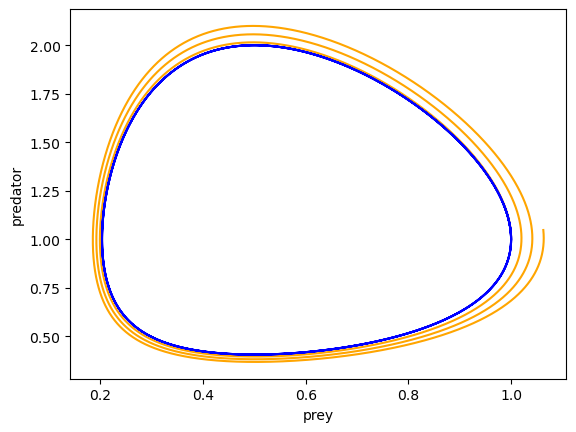

In [29]:
alpha = 1
beta = 1
gamma = 1
delta = 2
t_0 = 0
t_f = 20
tau = 0.005
N = 10**4

## Solve the system with and without delay
h, t, y_lv_0 = RK4sys_ode(LV(alpha, beta, gamma, delta), phi_LV(0), t_0, t_f, N)
h, t, y_lv = RK4sys_dde(LotkaVolterra(alpha, beta, gamma, delta), phi_LV, t_0, t_f, tau, N, False)

prey_0 = y_lv_0[:,0]
predator_0 = y_lv_0[:,1]
prey = y_lv[:,0]
predator = y_lv[:,1]

"""
plt.plot(t, prey, color='green', label='prey')
plt.plot(t, predator, color='red', label='predator')
plt.legend()
plt.show()
"""

plt.plot(prey, predator, color='orange')
plt.plot(prey_0, predator_0, color='blue')
plt.xlabel('prey')
plt.ylabel('predator')

# Testing Newton interpolation code:

In [108]:
def y_delayed_newton_backward(t, y, t_q, number_pts):

    j = np.searchsorted(t, t_q) - 1
    max_pts = 2*j + 1
    pts = min(number_pts, max_pts)
    shift = int(np.floor(pts / 2))

    idx = np.arange(j - pts + shift + 1, j + shift + 1)
    t_sub = t[idx]
    y_sub = y[idx]

    coef = np.array(y_sub, dtype=float)

    for k in range(1, pts):
        for i in range(pts - 1 , k - 1, -1):
            coef[i] = (coef[i] - coef[i-1]) / (t_sub[i] - t_sub[i-k])

    p = coef[pts-1]
    for k in range(pts-2, -1, -1):
        p = coef[k] + (t_q - t_sub[k]) * p

    return p

## Note: In case of explicit methods, we must make sure that (floor(number_pts / 2) - 1) * h < tau,
## otherwise the interpolation will ask for values of y which have not yet been calculated.
## In fact, for implicit methods, we need floor(number_pts / 2) * h < tau.


## Implicit Euler
def IE_newton_dde(f, phi, t_0, t_f, tau, N, history=False, pts=5):

    ## Preliminaries
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros(len(t))
    y[0] = phi(t_0)
    
    ## IE with linear interpolation for delay term
    for i in range(0, N):
        if t[i] < tau:
            y_impl = lambda x : -x + y[i] + h*f(t[i+1], x, phi(t[i+1] - tau))
            y[i+1] = fsolve(y_impl, [y[i]])[0]
        else:
            y_impl = lambda x : -x + y[i] + h*f(t[i+1], x, y_delayed_newton_backward(t, y, t[i+1] - tau,pts))
            y[i+1] = fsolve(y_impl, [y[i]])[0]

    if history == True: ## Wether the solution should include the history (values on the interval [t_0 - tau, t_0])
        t_hist = np.linspace(t_0-tau, t_0, int(N / (t_f // tau) + 1))
        y_hist = np.array([phi(ti) for ti in t_hist])
        t = np.concatenate((t_hist, t))
        y = np.concatenate((y_hist, y))

    return h, t, y

In [114]:
def RK4_newton(f, phi, t_0, t_f, tau, N, history=False, pts=4):

    ## Preliminaries
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y = np.zeros(len(t))
    y[0] = phi(t_0)

    ## RK4 with linear interpolation for delay term
    for i in range(0, N):
        if t[i] < tau:
            k1 = f(t[i], y[i], phi(t[i] - tau))
            k2 = f(t[i] + 0.5*h, y[i] + h*0.5*k1, phi(t[i] + 0.5*h - tau))
            k3 = f(t[i] + 0.5*h, y[i] + h*0.5*k2, phi(t[i] + 0.5*h - tau))
            k4 = f(t[i] + h, y[i] + h*k3, phi(t[i] + h - tau))
            y[i+1] = y[i] + h*(k1/6 + k2/3 + k3/3 + k4/6)
        else:
            k1 = f(t[i], y[i], y_delayed_newton_backward(t, y, t[i] - tau, pts))
            k2 = f(t[i] + 0.5*h, y[i] + h*0.5*k1, y_delayed_newton_backward(t, y, t[i] + 0.5*h - tau, pts))
            k3 = f(t[i] + 0.5*h, y[i] + h*0.5*k2, y_delayed_newton_backward(t, y, t[i] + 0.5*h - tau, pts))
            k4 = f(t[i] + h, y[i] + h*k3, y_delayed_newton_backward(t, y, t[i] + h - tau, pts))
            y[i+1] = y[i] + h*(k1/6 + k2/3 + k3/3 + k4/6)

    if history == True: ## Wether the solution should include the history (values on the interval [t_0 - tau, t_0])
        t_hist = np.linspace(t_0-tau, t_0, int(N / (t_f // tau) + 1))
        y_hist = np.array([phi(ti) for ti in t_hist])
        t = np.concatenate((t_hist, t))
        y = np.concatenate((y_hist, y))

    return h, t, y

C:\Users\marto\AppData\Local\Temp\ipykernel_23228\2944199056.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y[i+1] = fsolve(y_impl, [y[i]])[0]
C:\Users\marto\AppData\Local\Temp\ipykernel_23228\1485517504.py:42: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y[i+1] = fsolve(y_impl, [y[i]])[0]


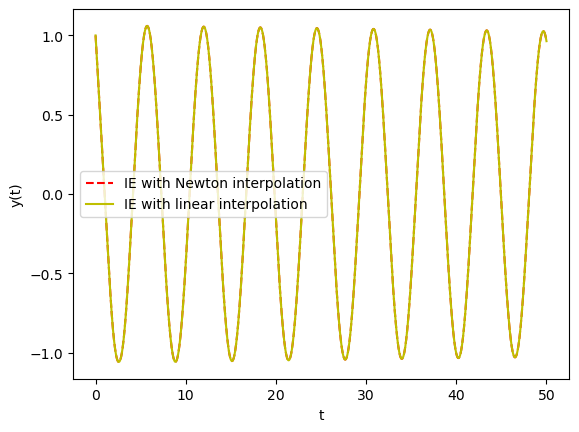

In [33]:
import matplotlib.pyplot as plt

a = 1
t_0 = 0
t_f = 50
tau = np.pi / 2
N = 10**4

h, t, y_L = IE(simple(a), phi_0, t_0, t_f, tau, N, False)
h, t, y_N = IE_newton_dde(simple(a), phi_0, t_0, t_f, tau, N, False, pts=4)
exact = simple_exact(a, t_0, t_f, tau, N)

#plt.plot(t, exact, color='blue', label='exact')
plt.plot(t, y_N, 'r--', label='IE with Newton interpolation')
plt.plot(t, y_L, 'y', label='IE with linear interpolation')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
#plt.plot(t, np.zeros(len(t)), color='black')

In [116]:
#Initial values
a = np.pi / 2 - 0.1
t_0 = 0
t_f = 30
tau = 1


maxnormresult = []
orderresult = []

N = 30 #I changed N (again)

for i in range(0,8):
    h, t, y = RK4_newton(simple(a), phi_0, t_0, t_f, tau, N*2**i, False, 4)
    exact = simple_exact(a, t_0, t_f, tau, N*2**i)
    maxnorm = np.linalg.norm(exact - y,np.inf)
    maxnormresult.append(maxnorm)
    
errorvector = np.hstack(maxnormresult)


for i in range(0,len(errorvector)-1):
    order = np.log2(errorvector[i]/errorvector[i+1])
    orderresult.append(order)
    
print(orderresult)
print(errorvector)

IndexError: index -2 is out of bounds for axis 0 with size 0

In [76]:
#Initial values
a = np.pi / 2 - 0.1
t_0 = 0
t_f = 30
tau = 1


maxnormresult = []
orderresult = []

N = 30 #I changed N (again)

for i in range(0,8):
    h, t, y = Trapezoidal(simple(a), phi_0, t_0, t_f, tau, N*2**i, False)
    exact = simple_exact(a, t_0, t_f, tau, N*2**i)
    maxnorm = np.linalg.norm(exact - y,np.inf)
    maxnormresult.append(maxnorm)
    
errorvector = np.hstack(maxnormresult)  


for i in range(0,len(errorvector)-1):
    order = np.log2(errorvector[i]/errorvector[i+1])
    orderresult.append(order)
    
print(orderresult)
print(errorvector)

[2.1518957394600187, 1.8530784840743988, 1.9607039076919297, 1.9902007600541374, 1.9975515254375005, 1.999281603000524, 1.9998503251935786]
[5.64879382e-01 1.27107319e-01 3.51834441e-02 9.03873516e-03
 2.27508452e-03 5.69737241e-04 1.42505254e-04 3.56300098e-05]


# Test equation 2

In [100]:
## Constant one history function
def phi_1(t):
    return np.e ** (-t)


def simple_exact_e(t_0, t_f, tau, N):
    if t_0 != 0:
        raise ValueError("t_0 should be set to 0")
    t = np.linspace(t_0, t_f, N+1)
    return np.e ** (-t)

In [102]:
#Initial values
a = 1 / np.e
t_0 = 0
t_f = 30
tau = 1


maxnormresult = []
orderresult = []

N = 30 #I changed N (again)

for i in range(0,8):
    h, t, y = RK4_newton(simple(a), phi_1, t_0, t_f, tau, N*2**i, False, 4)
    exact = simple_exact_e(t_0, t_f, tau, N*2**i)
    maxnorm = np.linalg.norm(exact - y,np.inf)
    maxnormresult.append(maxnorm)
    
errorvector = np.hstack(maxnormresult)


for i in range(0,len(errorvector)-1):
    order = np.log2(errorvector[i]/errorvector[i+1])
    orderresult.append(order)
    
print(orderresult)
print(errorvector)

[1.834185983560259, 1.9133309699070873, 1.9557682163301529, 1.9770897121628617, 1.988877133410079, 1.9945671508703884, 1.997318365722812]
[9.67779776e-02 2.71413561e-02 7.20545699e-03 1.85744786e-03
 4.71794990e-04 1.18861621e-04 2.98275175e-05 7.47075287e-06]


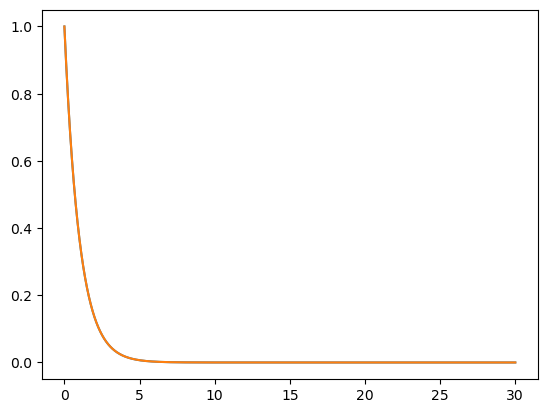

In [106]:
h, t, y = Trapezoidal(simple(a), phi_1, t_0, t_f, tau, N*2**i, False)
exact = simple_exact_e(t_0, t_f, tau, N*2**i)
plt.plot(t, y)
plt.plot(t, exact)